In [1]:
import torch
import numpy as np

from neurocode.datasets import SLEMEG, RecordingDataset
from neurocode.samplers import RecordingSampler, ScalogramSampler, SignalSampler
from neurocode.models import SignalNet, ResNet18, ProjectionHead
from neurocode.training import SimCLR
from neurocode.datautil import manifold_plot, history_plot
from braindecode.datautil.windowers import create_fixed_length_windows
from braindecode.datautil.preprocess import preprocess, Preprocessor, zscore
from pytorch_metric_learning import losses

torch.manual_seed(73)
np.random.seed(73)


In [7]:
manifold = 'tSNE'
load_model_ = False
subjects = list(range(0, 34))
recordings = [0,1,2,3]
n_samples = 40
batch_size = 128
window_size_s = 5.
n_channels = 3
n_views = 2
n_epochs = 30
temperature = .1
sfreq = 200
window_size_samples = np.ceil(sfreq * window_size_s).astype(int)
emb_size = 256
latent_size = 100


In [3]:
preprocessors = [Preprocessor(lambda x: x*1e12)]
dataset = SLEMEG(subjects=subjects, recordings=recordings, preload=True,
        load_meg_only=True, preprocessors=preprocessors, cleaned=True)


Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-01_ses-con_task-rest_ec_ds_raw.fif...
    Range : 3200 ... 64799 =     16.000 ...   323.995 secs
Ready.
Reading 0 ... 61599  =      0.000 ...   307.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-01_ses-con_task-rest_eo_ds_raw.fif...
    Range : 6600 ... 68799 =     33.000 ...   343.995 secs
Ready.
Reading 0 ... 62199  =      0.000 ...   310.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-01_ses-psd_task-rest_ec_ds_raw.fif...
    Range : 400 ... 63399 =      2.000 ...   316.995 secs
Ready.
Reading 0 ... 62999  =      0.000 ...   314.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-01_ses-psd_task-rest_eo_ds_raw.fif...
    Range : 6600 ... 76399 =     33.000 ...   381.995 secs
Ready.
Reading 0 ... 69799  =      0.000 ...   348.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-02_ses-con_task-

Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-10_ses-con_task-rest_ec_ds_raw.fif...
    Range : 2200 ... 66399 =     11.000 ...   331.995 secs
Ready.
Reading 0 ... 64199  =      0.000 ...   320.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-10_ses-con_task-rest_eo_ds_raw.fif...
    Range : 16000 ... 83799 =     80.000 ...   418.995 secs
Ready.
Reading 0 ... 67799  =      0.000 ...   338.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-10_ses-psd_task-rest_ec_ds_raw.fif...
    Range : 2000 ... 64199 =     10.000 ...   320.995 secs
Ready.
Reading 0 ... 62199  =      0.000 ...   310.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-10_ses-psd_task-rest_eo_ds_raw.fif...
    Range : 8400 ... 70799 =     42.000 ...   353.995 secs
Ready.
Reading 0 ... 62399  =      0.000 ...   311.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-11_ses-con_tas

Reading 0 ... 62599  =      0.000 ...   312.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-19_ses-con_task-rest_ec_ds_raw.fif...
    Range : 5200 ... 67399 =     26.000 ...   336.995 secs
Ready.
Reading 0 ... 62199  =      0.000 ...   310.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-19_ses-con_task-rest_eo_ds_raw.fif...
    Range : 9800 ... 72199 =     49.000 ...   360.995 secs
Ready.
Reading 0 ... 62399  =      0.000 ...   311.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-19_ses-psd_task-rest_ec_ds_raw.fif...
    Range : 4600 ... 66799 =     23.000 ...   333.995 secs
Ready.
Reading 0 ... 62199  =      0.000 ...   310.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-19_ses-psd_task-rest_eo_ds_raw.fif...
    Range : 10600 ... 72599 =     53.000 ...   362.995 secs
Ready.
Reading 0 ... 61999  =      0.000 ...   309.995 secs...
Opening raw data file D:\DA

Ready.
Reading 0 ... 62399  =      0.000 ...   311.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-28_ses-con_task-rest_ec_ds_raw.fif...
    Range : 6400 ... 68799 =     32.000 ...   343.995 secs
Ready.
Reading 0 ... 62399  =      0.000 ...   311.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-28_ses-con_task-rest_eo_ds_raw.fif...
    Range : 12200 ... 77399 =     61.000 ...   386.995 secs
Ready.
Reading 0 ... 65199  =      0.000 ...   325.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-28_ses-psd_task-rest_ec_ds_raw.fif...
    Range : 6800 ... 69399 =     34.000 ...   346.995 secs
Ready.
Reading 0 ... 62599  =      0.000 ...   312.995 secs...
Opening raw data file D:\DA231X-Degree-Project\data/data-cleaned/sub-28_ses-psd_task-rest_eo_ds_raw.fif...
    Range : 10400 ... 75799 =     52.000 ...   378.995 secs
Ready.
Reading 0 ... 65399  =      0.000 ...   326.995 secs...
Opening raw data fi

In [4]:
windows_dataset = create_fixed_length_windows(dataset, start_offset_samples=0,
        stop_offset_samples=0, drop_last_window=True, window_size_samples=window_size_samples,
        window_stride_samples=window_size_samples, preload=True)

preprocess(windows_dataset, [Preprocessor(zscore)])
dataset = RecordingDataset(windows_dataset.datasets, dataset.labels, sfreq=sfreq, channels='MEG')
train_dataset, valid_dataset = dataset.split_fixed()

samplers = {'train': RecordingSampler(train_dataset.get_data(), train_dataset.get_labels(),
    train_dataset.get_info(), n_channels=n_channels, n_views=n_views, n_samples=n_samples, batch_size=train_dataset.info['n_recordings']),
            'valid': RecordingSampler(valid_dataset.get_data(), valid_dataset.get_labels(),
    valid_dataset.get_info(), n_channels=n_channels, n_views=n_views, n_samples=n_samples, batch_size=valid_dataset.info['n_recordings'])}


Adding metadata with 4 columns
Replacing existing metadata with 4 columns
61 matching events found
No baseline correction applied
0 projection items activated
Loading data for 61 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
63 matching events found
No baseline correction applied
0 projection items activated
Loading data for 63 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
69 matching events found
No baseline correction applied
0 projection items activated
Loading data for 69 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Repla

C:\Users\wille\anaconda3\lib\site-packages\braindecode\datautil\windowers.py:174: UserWarning: Meaning of `trial_stop_offset_samples`=0 has changed, use `None` to indicate end of trial/recording. Using `None`.
  warnings.warn(


0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
60 matching events found
No baseline correction applied
0 projection items activated
Loading data for 60 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
61 matching events found
No baseline correction applied
0 projection items activated
Loading data for 61 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata

0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
63 matching events found
No baseline correction applied
0 projection items activated
Loading data for 63 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
63 matching events found
No baseline correction applied
0 projection items activated
Loading data for 63 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
63 matching events found
No baseline correction applied
0 projection items activated
Loading data for 63 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata

0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
63 matching events found
No baseline correction applied
0 projection items activated
Loading data for 63 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata

0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
65 matching events found
No baseline correction applied
0 projection items activated
Loading data for 65 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
62 matching events found
No baseline correction applied
0 projection items activated
Loading data for 62 events and 1000 original time points ...
0 bad epochs dropped
Adding metadata

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#model = SignalNet(n_channels, sfreq, input_size_s=window_size_s, n_filters=16, apply_batch_norm=True).to(device)
model = SignalNet(n_channels, sfreq, input_size_s=window_size_s, n_filters=16, apply_batch_norm=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(samplers['train']),
        eta_min=0, last_epoch=-1)
criterion = losses.NTXentLoss(temperature=temperature)

simclr = SimCLR(model, device, optimizer=optimizer, scheduler=scheduler,
        criterion=criterion, batch_size=1, epochs=n_epochs, 
        temperature=temperature, n_views=n_views)


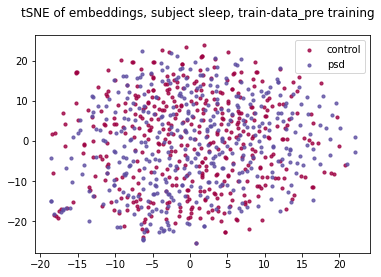

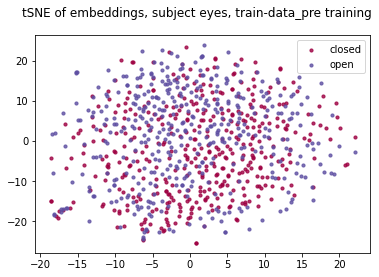

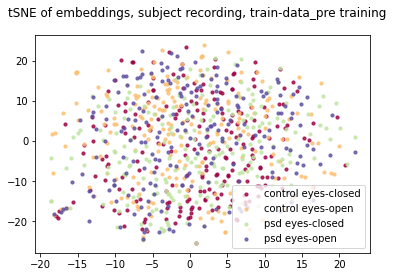

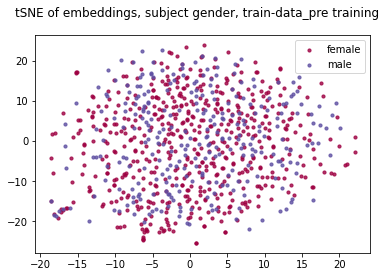

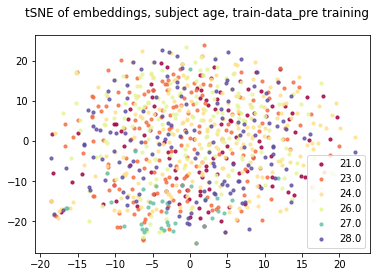

No handles with labels found to put in legend.


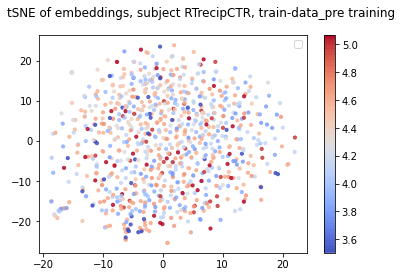

No handles with labels found to put in legend.


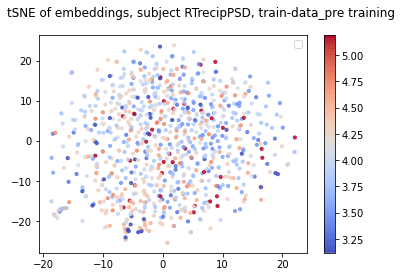

No handles with labels found to put in legend.


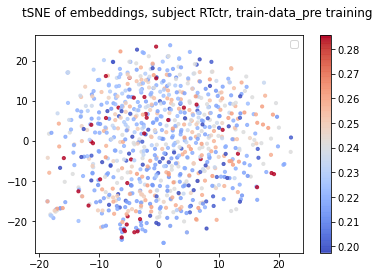

No handles with labels found to put in legend.


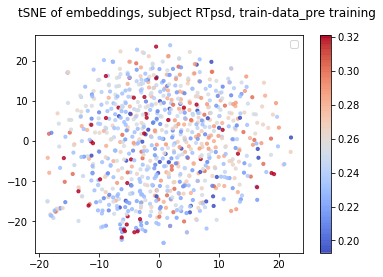

No handles with labels found to put in legend.


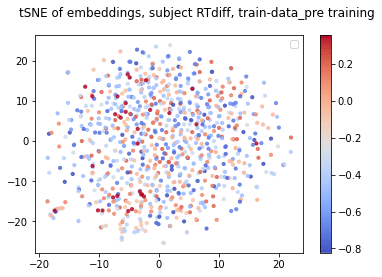

No handles with labels found to put in legend.


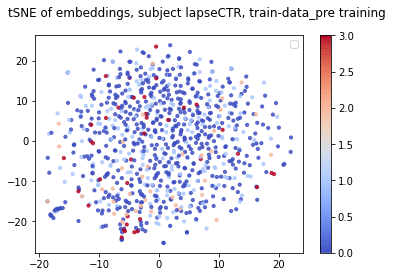

No handles with labels found to put in legend.


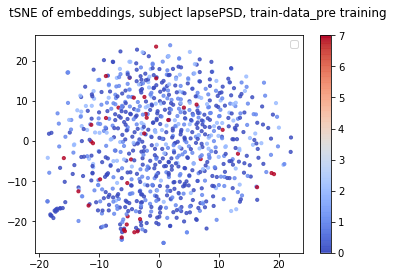

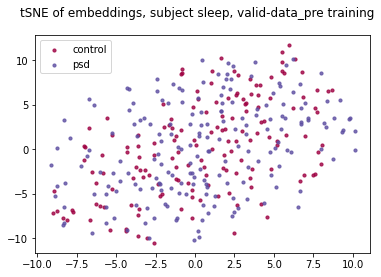

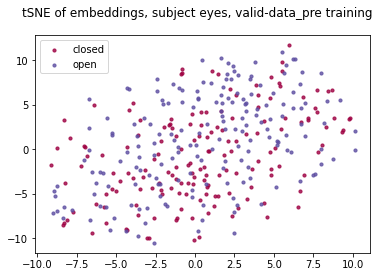

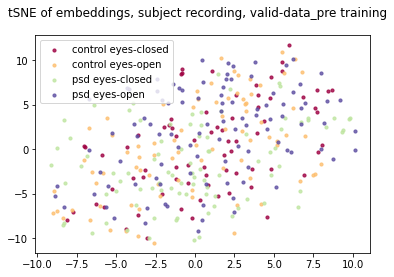

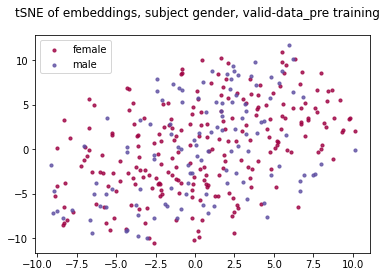

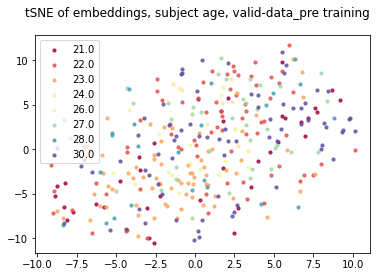

No handles with labels found to put in legend.


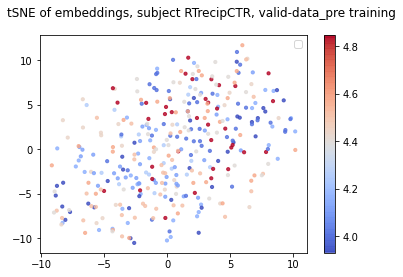

No handles with labels found to put in legend.


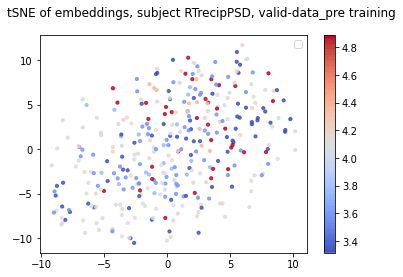

No handles with labels found to put in legend.


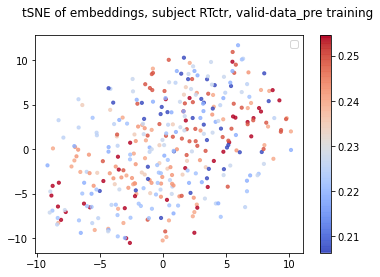

No handles with labels found to put in legend.


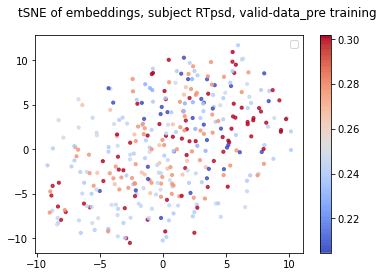

No handles with labels found to put in legend.


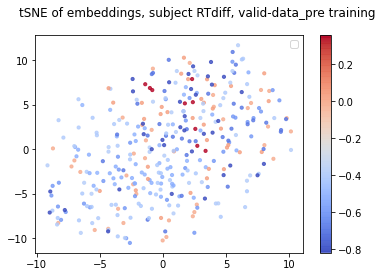

No handles with labels found to put in legend.


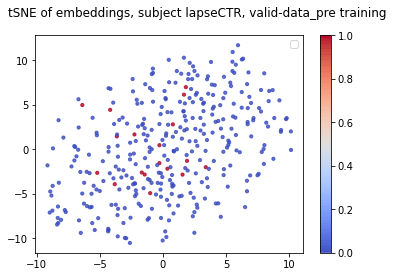

No handles with labels found to put in legend.


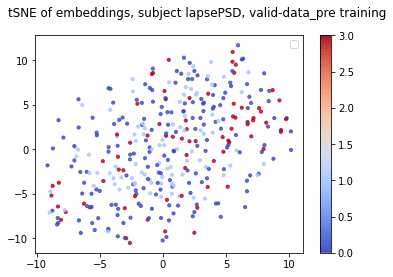

Training encoder with SimCLR on device=cuda for 30 epochs
   epoch       training loss       validation loss         training acc        validation acc
------------------------------------------------------------------------------------------------
     01            5.1910              4.1886                  0.00%                 0.00%
     02            4.9967              4.2248                  0.00%                 0.00%
     03            4.8751              3.9502                  0.00%                 0.00%
     04            4.6153              3.8218                  0.00%                 0.00%
     05            4.4411              3.6731                  0.00%                 0.00%
     06            4.3108              3.6546                  0.00%                 0.00%
     07            4.2590              3.6447                  0.00%                 0.00%
     08            4.1348              3.4858                  0.00%                 0.00%
     09            4.07

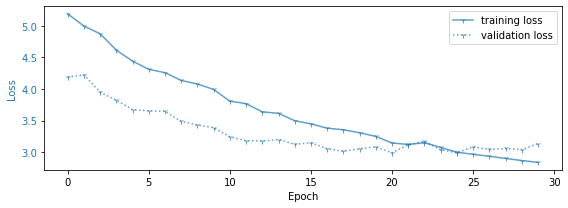

<Figure size 432x288 with 0 Axes>

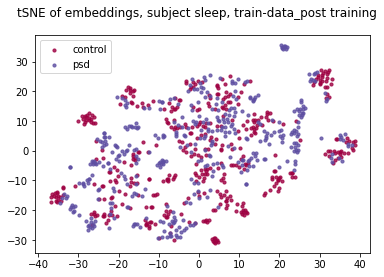

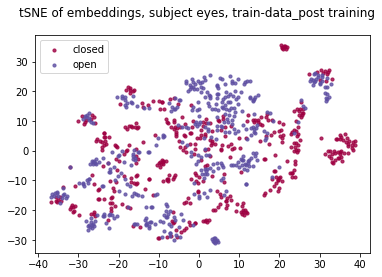

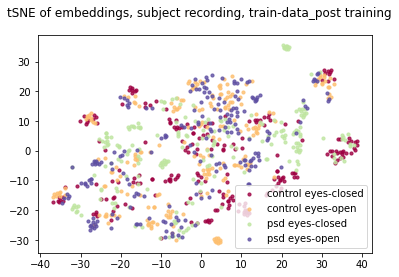

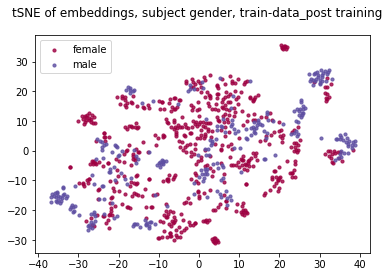

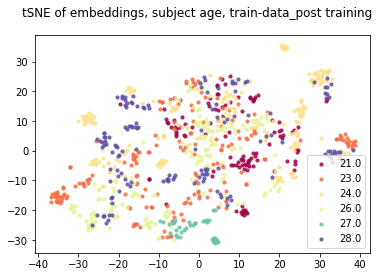

No handles with labels found to put in legend.


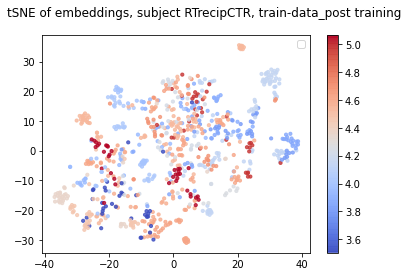

No handles with labels found to put in legend.


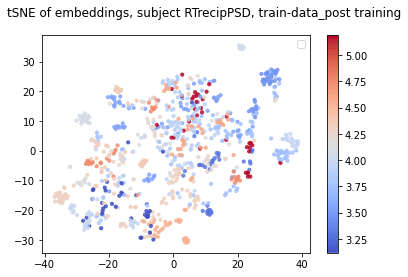

No handles with labels found to put in legend.


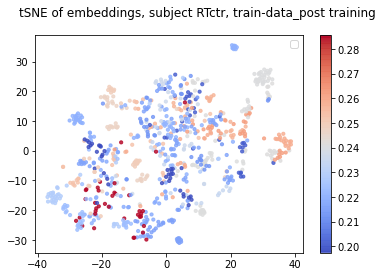

No handles with labels found to put in legend.


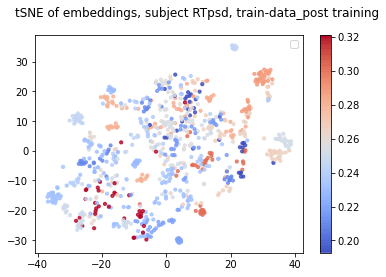

No handles with labels found to put in legend.


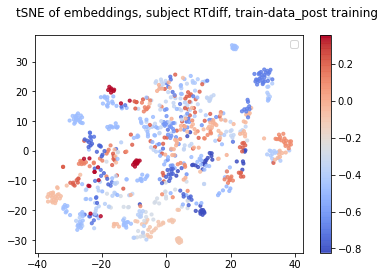

No handles with labels found to put in legend.


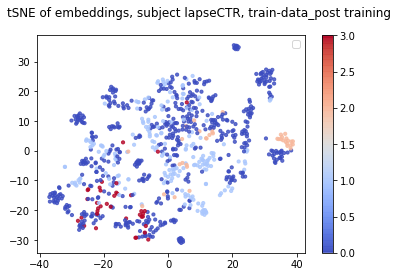

No handles with labels found to put in legend.


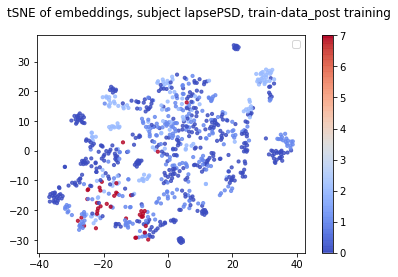

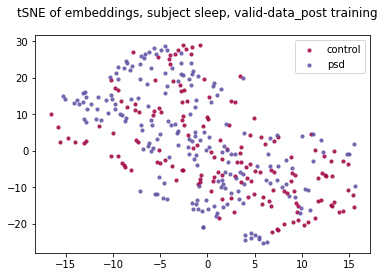

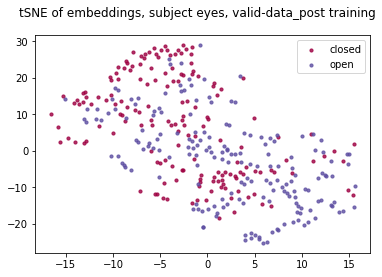

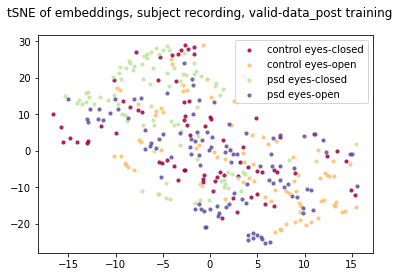

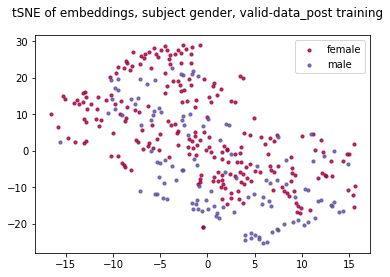

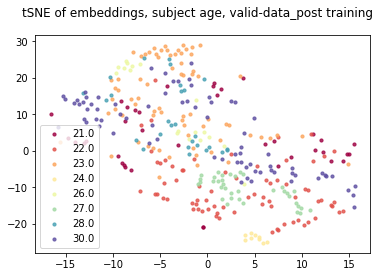

No handles with labels found to put in legend.


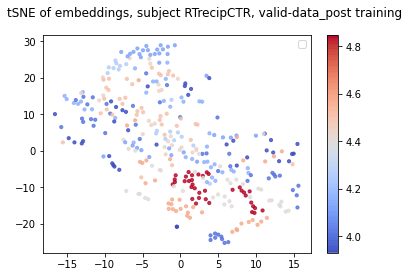

No handles with labels found to put in legend.


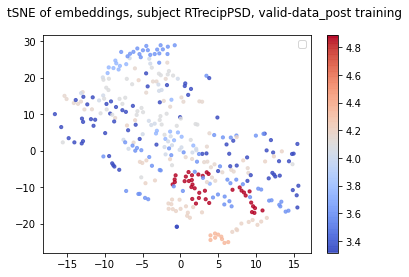

No handles with labels found to put in legend.


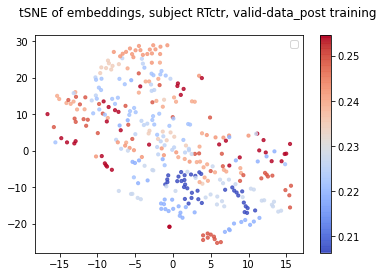

No handles with labels found to put in legend.


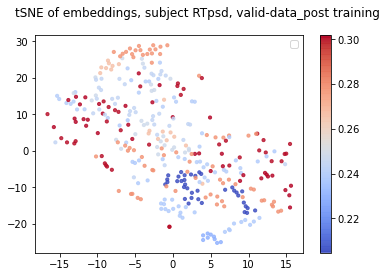

No handles with labels found to put in legend.


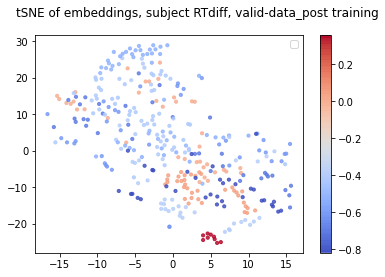

No handles with labels found to put in legend.


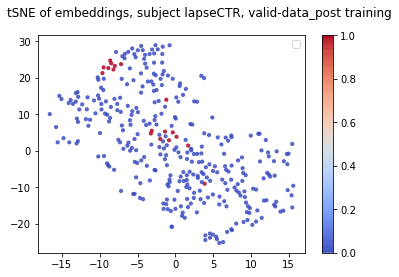

No handles with labels found to put in legend.


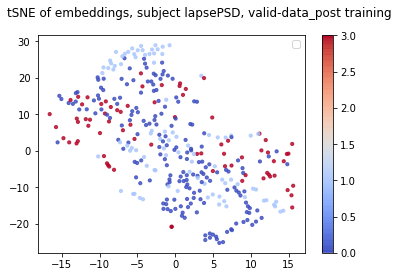

In [9]:
# extract features from both training and validation set, apply tSNE and visualize subject labels
manifold_plot(samplers['train']._extract_features(model, device), 'train-data_pre', technique=manifold)
manifold_plot(samplers['valid']._extract_features(model, device), 'valid-data_pre', technique=manifold)

# train the encoder f()
print(f'Training encoder with SimCLR on device={device} for {n_epochs} epochs')
print(f'   epoch       training loss       validation loss         training acc        validation acc')
print(f'------------------------------------------------------------------------------------------------')
history = simclr.fit(samplers, plot=False, save_model=True)
history_plot(history)

# visualize features again, both training and validation set, but now post training
manifold_plot(samplers['train']._extract_features(model, device), 'train-data_post', technique=manifold)
manifold_plot(samplers['valid']._extract_features(model, device), 'valid-data_post', technique=manifold)
